In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer

In [35]:
df = pd.read_csv('training_set_features.csv')
df.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [36]:
df_labels = pd.read_csv('training_set_labels.csv')
df_labels.head()

,respondent_id,xyz_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [37]:
df.isnull().sum()

respondent_id                      0
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [38]:
df.drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

In [39]:
df.isnull().sum()

respondent_id                     0
xyz_concern                      92
xyz_knowledge                   116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_xyz                2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_xyz_vacc_effective      391
opinion_xyz_risk                388
opinion_xyz_sick_from_vacc      395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                 

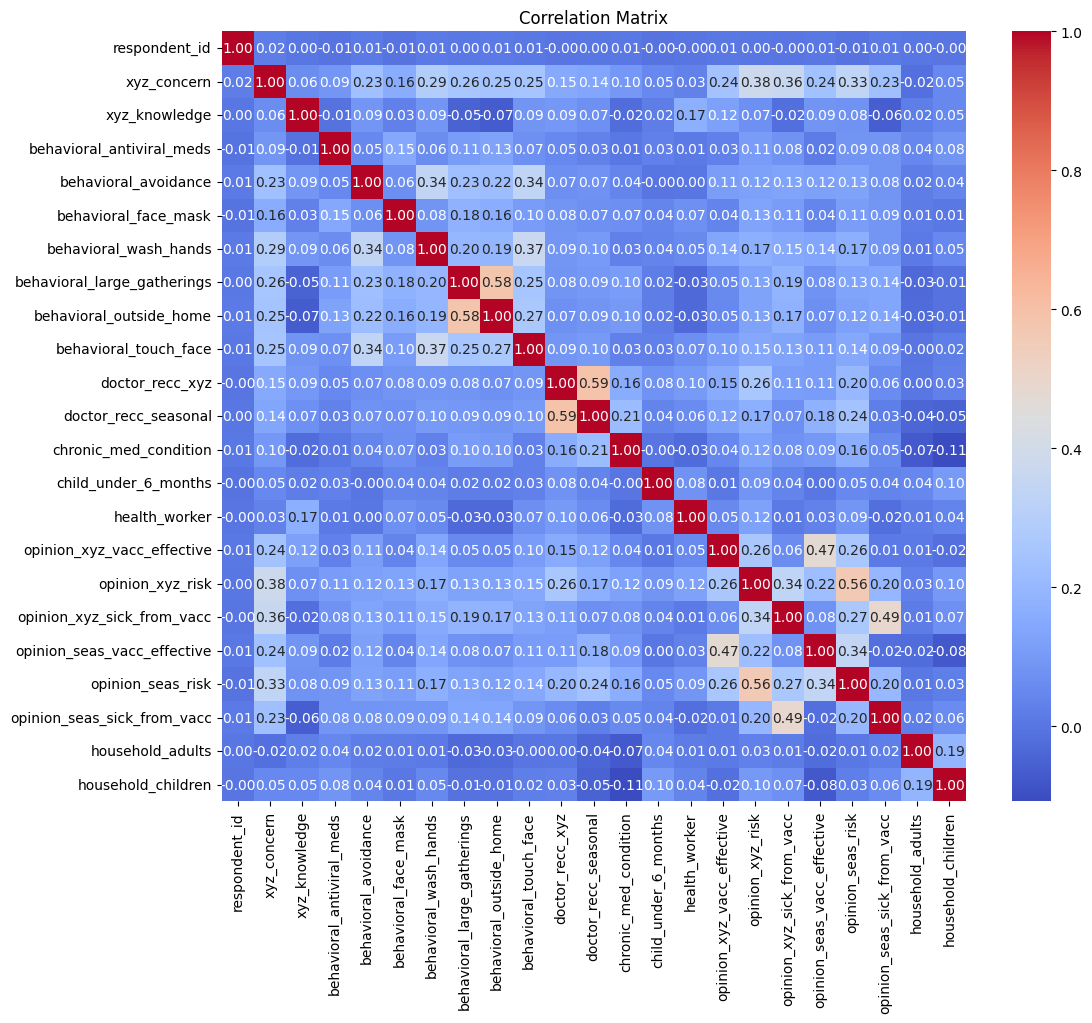

In [53]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [57]:
train_features = pd.read_csv('training_set_features.csv').drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1)
train_labels = pd.read_csv('training_set_labels.csv')

data = pd.merge(train_features, train_labels, on='respondent_id')

X = data.drop(columns=['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'])
y = data[['xyz_vaccine', 'seasonal_vaccine']]

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = MultiOutputClassifier(RandomForestClassifier(random_state=42))

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

y_valid_pred = clf.predict(X_valid)
y_valid_proba = clf.predict_proba(X_valid)

In [58]:
test_features = pd.read_csv('test_set_features.csv').drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1)

X_test_final = test_features.drop(columns=['respondent_id'])
y_test_final_pred = clf.predict(X_test_final)
y_test_final_pred_df = pd.DataFrame(y_test_final_pred, columns=['xyz_vaccine', 'seasonal_vaccine'])
y_test_final_pred_df['respondent_id'] = test_features['respondent_id']

y_test_final_pred_df.set_index('respondent_id', inplace=True)

roc_auc_xyz_vaccine = roc_auc_score(y_valid['xyz_vaccine'], y_valid_proba[0][:, 1])
roc_auc_seasonal_vaccine = roc_auc_score(y_valid['seasonal_vaccine'], y_valid_proba[1][:, 1])

mean_roc_auc = (roc_auc_xyz_vaccine + roc_auc_seasonal_vaccine) / 2

In [59]:
#print(f'Mean ROC AUC Score: {mean_roc_auc}')

y_test_final_pred_df.to_csv('predictions.csv', index=True)
y_test_final_pred_df

Mean ROC AUC Score: 0.8388794825519797


,xyz_vaccine,seasonal_vaccine
respondent_id,,
26707,0,0
26708,0,0
26709,1,1
26710,1,1
26711,0,0
...,...,...
53410,0,1
53411,0,0
53412,0,0
